✅ Combined feature shape: (1311, 132)
📊 Silhouette Score: 0.1601978820103497
🩺 Healthy-like cluster: 0
Building DataFrame with 1311 samples
✅ Created Progression DataFrame successfully!
                     Image  Cluster  Homogeneity  ProgressionIndex   Stage
0  glioma/Te-glTr_0000.jpg        2     0.624157          0.082822  Normal
1  glioma/Te-glTr_0001.jpg        0     0.679048          0.074748  Normal
2  glioma/Te-glTr_0002.jpg        0     0.797065          0.305635  Normal
3  glioma/Te-glTr_0003.jpg        0     0.621158          0.070659  Normal
4  glioma/Te-glTr_0004.jpg        2     0.670303          0.069100  Normal


/tmp/ipython-input-1413618004.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Stage', data=df_prog, palette='coolwarm')


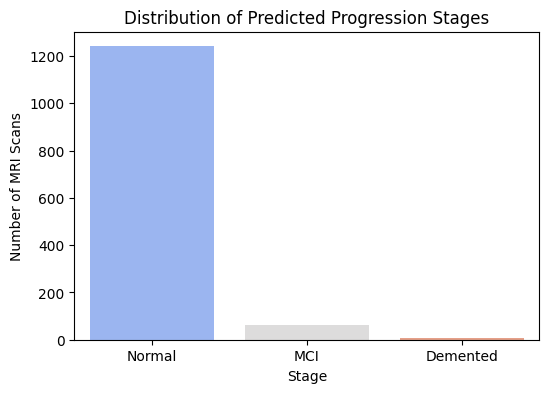

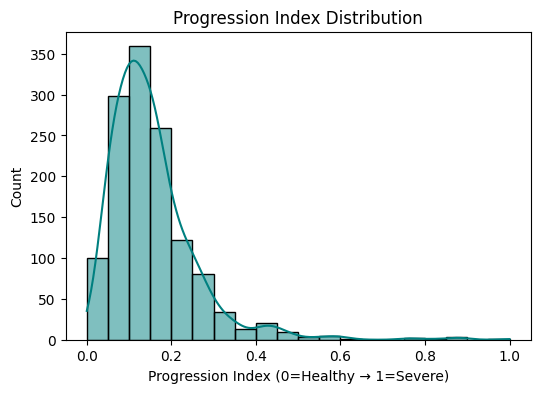

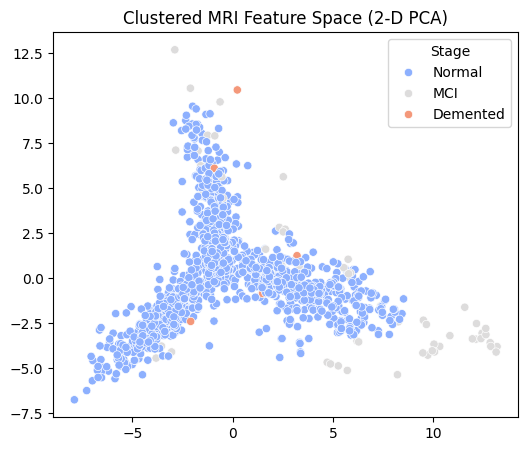

📈 Stage-wise progression statistics:
      Stage      mean       std  count
0  Demented  0.854952  0.082812      7
1       MCI  0.425019  0.075867     63
2    Normal  0.137378  0.068144   1241


In [ ]:
# ============================================================
# STEP 1️⃣  Combine CNN and texture features
# ============================================================
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances

# ---- compute per-image GLCM features (reuse earlier function)
glcm_feats = [texture_features(p) for p in test_generator.filepaths]
df_glcm = pd.DataFrame(glcm_feats)
df_glcm['path'] = test_generator.filepaths

# ---- scale both CNN and GLCM before fusion
scaler_img = StandardScaler()
X_cnn = scaler_img.fit_transform(features)

scaler_tex = StandardScaler()
X_tex = scaler_tex.fit_transform(df_glcm[['contrast','homogeneity','energy','correlation']])

# ---- concatenate CNN + GLCM features
X_combined = np.hstack((X_cnn, X_tex))
print("✅ Combined feature shape:", X_combined.shape)

# ============================================================
# STEP 2️⃣  Cluster into 3 groups (Normal / MCI / Demented)
# ============================================================
K = 3
km = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = km.fit_predict(X_combined)
print("📊 Silhouette Score:", silhouette_score(X_combined, clusters))

# ============================================================
# STEP 3️⃣  Identify the 'Healthy-like' cluster
# ============================================================
# use average homogeneity: higher → healthier
df_glcm['cluster'] = clusters
cluster_homogeneity = df_glcm.groupby('cluster')['homogeneity'].mean()
healthy_cluster = int(cluster_homogeneity.idxmax())
print(f"🩺 Healthy-like cluster: {healthy_cluster}")

# ============================================================
# STEP 4️⃣  Compute progression index (distance from healthy)
# ============================================================
dists = pairwise_distances(X_combined, km.cluster_centers_[healthy_cluster].reshape(1,-1))
progression_index = (dists - dists.min()) / (dists.max() - dists.min())

# thresholds → stages
def prog_to_stage(p):
    if p < 0.33: return "Normal"
    elif p < 0.66: return "MCI"
    else: return "Demented"

stages = np.vectorize(prog_to_stage)(progression_index)

# ============================================================
# STEP 5️⃣: Create Results DataFrame (Fully Fixed)
# ============================================================

# Ensure all arrays are 1-D and same length
progression_index_flat = np.ravel(progression_index)
homogeneity_flat = np.ravel(df_glcm['homogeneity'].values)
stages_flat = np.ravel(stages)
clusters_flat = np.ravel(clusters)
filenames_flat = np.ravel(test_generator.filenames)

# Sanity check
n = min(len(filenames_flat), len(clusters_flat), len(homogeneity_flat), len(progression_index_flat), len(stages_flat))
print(f"Building DataFrame with {n} samples")

df_prog = pd.DataFrame({
    'Image': filenames_flat[:n],
    'Cluster': clusters_flat[:n],
    'Homogeneity': homogeneity_flat[:n],
    'ProgressionIndex': progression_index_flat[:n],
    'Stage': stages_flat[:n]
})

print("✅ Created Progression DataFrame successfully!")
print(df_prog.head())


# ============================================================
# STEP 6️⃣  Visualize stage distribution & progression score
# ============================================================
plt.figure(figsize=(6,4))
sns.countplot(x='Stage', data=df_prog, palette='coolwarm')
plt.title("Distribution of Predicted Progression Stages")
plt.ylabel("Number of MRI Scans")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_prog['ProgressionIndex'], bins=20, kde=True, color='teal')
plt.title("Progression Index Distribution")
plt.xlabel("Progression Index (0=Healthy → 1=Severe)")
plt.show()

# ---- optional 2-D PCA visualization
pca = PCA(n_components=2).fit_transform(X_combined)
plt.figure(figsize=(6,5))
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=df_prog['Stage'], palette='coolwarm')
plt.title("Clustered MRI Feature Space (2-D PCA)")
plt.show()

# ============================================================
# STEP 7️⃣  Summary statistics
# ============================================================
summary = df_prog.groupby('Stage')['ProgressionIndex'].agg(['mean','std','count']).reset_index()
print("📈 Stage-wise progression statistics:")
print(summary)
